In [1]:
from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing
from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
beta = 0.9999
init_dict = {
    "groups": "group_4",
    "beta": beta,
    "maint_func": "linear",
    "binsize": 5000,
    "states": 90,
}

In [3]:
data_reading()
repl_data = data_processing(init_dict)
trans_results, cost_results = estimate(init_dict, repl_data, repl_4=True)
print(trans_results, cost_results)

{'state_count': array([[68, 94,  9, ...,  0,  0,  0],
       [ 0, 44, 59, ...,  0,  0,  0],
       [ 0,  0, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1]]), 'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': array([1682, 2555,   55])}       fun: 163.58583993344618
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16529009e-04, -3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([10.07759093,  2.29408834])


In [4]:
max_state = trans_results["state_count"].shape[0]  # 78
scale = 3
num_bins = int(max_state / scale)  # 26

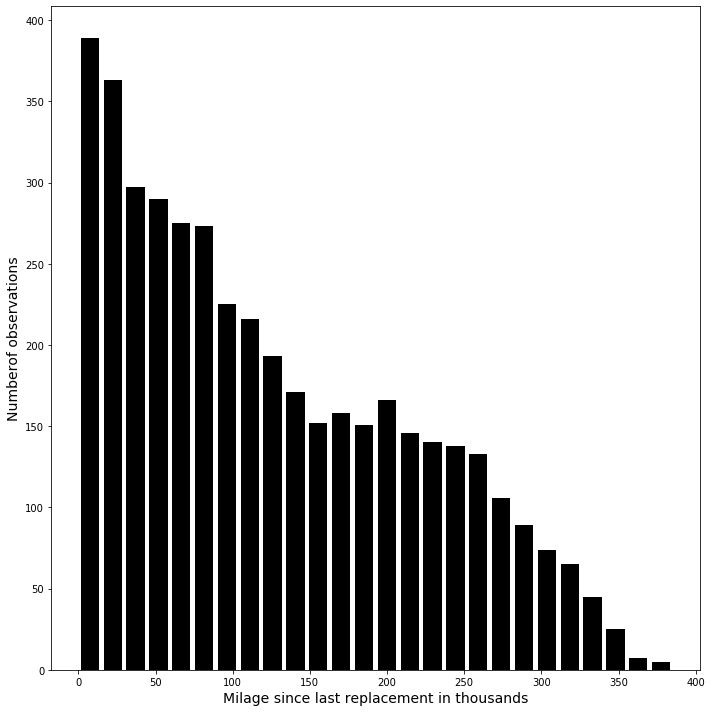

In [5]:
numobs_per_state = trans_results["state_count"].sum(axis=1)
hist_data = np.array([])
for i, val in enumerate(numobs_per_state):
    hist_data = np.append(hist_data, np.full(val, i))
hist_data = hist_data * init_dict["binsize"] / 1000

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_ylabel(r"Numberof observations", fontsize=14)
ax.set_xlabel(r"Milage since last replacement in thousands", fontsize=14)
# ax.set_ylim([0, 1.15 * numobs_per_state[0]])
ax.hist(hist_data, bins=num_bins, color="black", rwidth=0.8)
plt.tight_layout()
plt.savefig("figures/obs_per_miles.png")
plt.show()

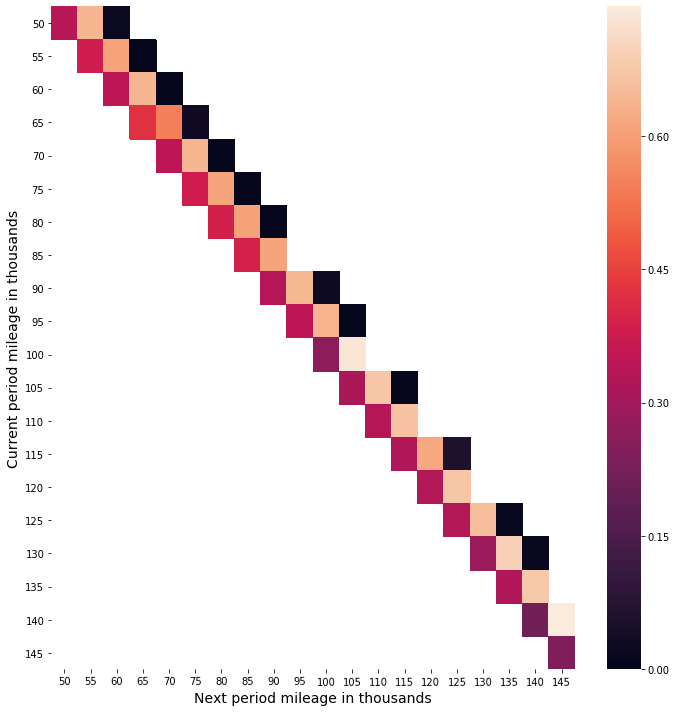

In [6]:
state_mat = trans_results["state_count"]
trans_mat = state_mat / state_mat.sum(axis=1)[:, None]
trans_mask = trans_mat == 0
start = 10
end = 30
index = range(start * 5, end * 5, 5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    trans_mat[start:end, start:end],
    mask=trans_mask[start:end, start:end],
    ax=ax,
    xticklabels=index,
    yticklabels=index,
)
ax.set_ylabel(r"Current period mileage in thousands", fontsize=14)
ax.set_xlabel(r"Next period mileage in thousands", fontsize=14)
plt.xticks(rotation=1)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/trans_mat.png")
plt.show()

In [7]:
from ruspy.plotting.prob_simplex import Kullback_Leibler

def create_set(
    p_ml,
    roh,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
    set_method="Kullback",
):
    """
    This function evaluates points in a given grid and returns their coordinate if
    they are in the given set.
    :param p_ml: Middle point of set
    :param roh: set size
    :param step: stepsize for grid
    :param min_grid_p_0: minimal value of p_0 in the grid
    :param min_grid_p_1: minimal value of p_1 in the grid
    :param max_grid_p_0: maximal value of p_0 in the grid
    :param max_grid_p_1: maximal value of p_1 in the grid
    :param set_method: Method to calculate distance between probability vectors
    :return:
    """
    if set_method == "Kullback":
        set_cond = Kullback_Leibler
    else:
        raise ValueError("Set measure not supported.")
    set_coordinates = np.empty(shape=(1, 2))
    for p_0 in np.arange(min_grid_p_0, max_grid_p_0, step):
        for p_1 in np.arange(min_grid_p_1, max_grid_p_1, step):
            p = np.array([p_0, p_1, 1 - p_0 - p_1])
            if p[(p > 0) & (p < 1)].size == p.size:
                if roh - Kullback_Leibler(p, p_ml) >= 0:
                    set_coordinates = np.append(set_coordinates, [[p_0, p_1]], axis=0)
    return set_coordinates[1:]

In [8]:
import scipy as sc
p_ml_0 = 0.4
p_ml_1 = 0.25
p_ml_2 = 1 - p_ml_0 - p_ml_1
p_ml = np.array([p_ml_0, p_ml_1, p_ml_2])
rho = 0.06
min_grid_p_0 = min_grid_p_1 = 0
max_grid_p_0 = max_grid_p_1 = 1
step = 0.01
set_probs_pre = create_set(
    p_ml,
    rho,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
)
min_grid_p_0 = set_probs_pre[:, 0].min() - step
max_grid_p_0 = set_probs_pre[:, 0].max() + step
min_grid_p_1 = set_probs_pre[:, 1].min() - step
max_grid_p_1 = set_probs_pre[:, 1].max() + step
step = 0.001
set_probs = create_set(
    p_ml,
    rho,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
)
hull = sc.spatial.ConvexHull(set_probs)

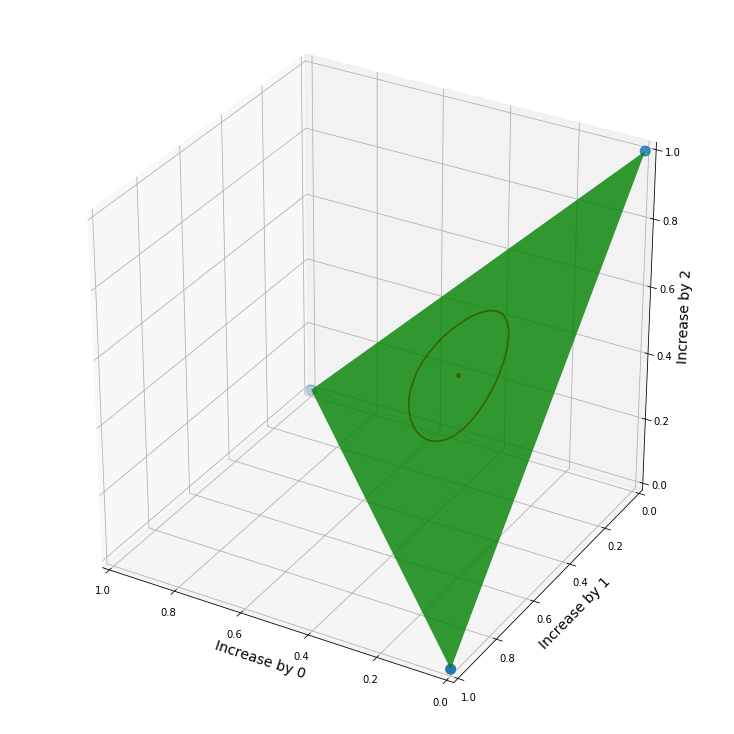

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
verts = [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
ax.set_xlim3d([1, 0])
ax.set_xlabel(r"Increase by 0", fontsize=14)
ax.set_ylim3d([1, 0])
ax.set_ylabel(r"Increase by 1", fontsize=14)
ax.set_zlim3d([0, 1])
ax.set_zlabel(r"Increase by 2", fontsize=14)

ax.scatter(verts[0], verts[1], zs=verts[2], s=100, label="True Position")
for simplex in hull.simplices:
    ax.plot3D(
        set_probs[simplex, 0],
        set_probs[simplex, 1],
        (1 - set_probs[simplex, 0] - set_probs[simplex, 1]),
        color="red",
    )
ax.plot3D([p_ml[0]], [p_ml[1]], [p_ml[2]], marker="o", markersize=4, color="red")
ax.add_collection3d(Poly3DCollection([verts], facecolor="green", alpha=0.8))
plt.savefig("figures/probability_simplex.png")
plt.show()